### Libraries and data loading

In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import matplotlib.dates as mdates

%matplotlib inline

2024-12-09 10:34:06.935800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 10:34:07.087151: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 10:34:07.129509: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 10:34:07.753841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# check tensorflow version
print("tensorflow version:", tf.__version__)
# check available gpu
gpus =  tf.config.list_physical_devices('GPU')
print("available gpus:", gpus)
# limit the gpu usage, prevent it from allocating all gpu memory for a simple model
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# check number of cpus available
print("available cpus:", os.cpu_count())

tensorflow version: 2.10.0
available gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
available cpus: 112


2024-12-09 10:34:08.900418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-09 10:34:08.900851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-09 10:34:08.909574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-09 10:34:08.909962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-09 10:34:08.910303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [3]:
import tensorflow as tf
sys_details = tf.sysconfig.get_build_info()
sys_details["cuda_version"]

'11.2'

In [4]:
# define the data location and load data

data_folder = os.path.join("data")
data_path = os.path.join(data_folder, "2017_2019_images_pv_processed.hdf5")

# !change model name for different models!
model_name = 'SUNSET_nowcast_2017_2019_data'
output_folder = os.path.join("model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: data
data_path: data/2017_2019_images_pv_processed.hdf5
output_folder: model_output/SUNSET_nowcast_2017_2019_data


In [5]:
# generate handler for the hdf5 data
forecast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(forecast_dataset[name])
    
forecast_dataset.visit(get_all)

<HDF5 group "/test" (2 members)>
<HDF5 dataset "images_log": shape (14003, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (14003,), type "<f8">
<HDF5 group "/trainval" (2 members)>
<HDF5 dataset "images_log": shape (349372, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (349372,), type "<f8">


In [6]:
print('-'*50)
# get the input dimension for constructing the model
img_side_len = forecast_dataset['trainval']['images_log'].shape[1]

num_log_term = forecast_dataset['trainval']['images_log'].shape[1]

num_color_channel = forecast_dataset['trainval']['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)

print("number of log terms:", num_log_term)

print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"times_trainval.npy"),allow_pickle=True)
print("times_trainval.shape:", times_trainval.shape)

# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch
num_samples = len(times_trainval)
batch_size = num_samples//5
indices = np.arange(num_samples)
print('-'*50)
print('data reading start...')
for i in range(int(num_samples / batch_size) + 1):
    start_time = time.time()
    start_idx = (i * batch_size) % num_samples
    idxs = indices[start_idx:start_idx + batch_size]
    _ = forecast_dataset['trainval']['images_log'][idxs]
    _ = forecast_dataset['trainval']['pv_log'][idxs]
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))

# temporially close the dataset, will use "with" statement to open it when we use it
forecast_dataset.close()

--------------------------------------------------
image side length: 64
number of log terms: 64
number of color channels: 3
input image dimension: [64, 64, 3]
times_trainval.shape: (349372,)
--------------------------------------------------
data reading start...
batch 1 samples: 0 to 69873, 20.00% finished, processing time 0.59s
batch 2 samples: 69874 to 139747, 40.00% finished, processing time 0.60s
batch 3 samples: 139748 to 209621, 60.00% finished, processing time 0.59s
batch 4 samples: 209622 to 279495, 80.00% finished, processing time 0.59s
batch 5 samples: 279496 to 349369, 100.00% finished, processing time 0.59s
batch 6 samples: 349370 to 349371, 100.00% finished, processing time 0.00s


### Input data pipeline helper functions

In [7]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):
    
    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [8]:
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [9]:
# a mapping function from the indices to the corresponding features and labels 
def data_loader(hdf5_data_path,sample_idx,batch_size=256):
    '''
    input:
    hdf5_data_path: path to hdf5 data file
    sample_idx: 
        for training and validation:
            dayblock shuffled indices with cross-validation split into training and validation
            either training or validation indices will be input
        for testing: the indices are not shuffled
    is_trainval: a flag, True for trainig and validation
    output:
    dataset: dataset for training, validation
    '''

    def mapping_func_py(hdf5_data_path,sample_idx):
        '''
        mapping indices to corresponding images and pviance data in hdf5 (python expression)
        '''
        # convert EagerTensor to str or numpy array
        hdf5_data_path = hdf5_data_path.numpy().decode() 
        # sort the sample indices as hdf5 requires increasing order index for data retrieval
        sample_idx = sorted(sample_idx.numpy())

        with h5py.File(hdf5_data_path,'r') as f:

            # read in the data
            images_log = f['trainval']['images_log'][sample_idx]
            pv_log = f['trainval']['pv_log'][sample_idx]

            # normalize image data to [0,1]
            images_log = tf.image.convert_image_dtype(images_log, tf.float32)
            
            # convert pv data to tf.tensor
            pv_log = tf.convert_to_tensor(pv_log, dtype=tf.float32)
            
            return images_log, pv_log

    def mapping_func_tf(hdf5_data_path,sample_idx):
        '''
        a wrapper mapping function to get the nested data structure 
        the output type of tf.py_function cannot be a nested sequence when using a tf.py_function with the tf.data API
        '''
        images_log, pv_log = tf.py_function(func=mapping_func_py,
                                                           inp=[hdf5_data_path, sample_idx], 
                                                           Tout=(tf.float32, tf.float32))
        return images_log, pv_log
    
    
    # create the indices dataset
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_idx)
    # shuffle and batch the indices
    idx_ds = idx_ds.shuffle(buffer_size = idx_ds.cardinality().numpy(),seed=0)
    idx_ds = idx_ds.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)
    
    # indices dataset mapping to images and pviance data
    # returning dataset with the following nested structure: (images_log, pv_log), pv_pred
    dataset = idx_ds.map(lambda x: mapping_func_tf(hdf5_data_path,x),
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

### Model architecture

In [12]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Concatenate, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0: All logs, 1: Info, 2: Warnings, 3: Errors

# define model characteristics 
num_filters = 24
kernel_size = [3,3]
pool_size = [2,2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 5 # 5-fold cross-validation
batch_size = 256
learning_rate = 3e-06
# Model architecture definition
def sunset_model():
    ## input
    x_in = keras.Input(shape=image_input_dim)  # Input image logs with shape (64,64,24)

    ## 1st convolution block
    x = Conv2D(num_filters // 2, kernel_size, padding="same", activation='relu')(x_in)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block
    x = Conv2D(num_filters, kernel_size, padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size, strides)(x)

    # Flatten the convolution output for connection with Dense layers
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(drop_rate)(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(drop_rate)(x)

    ## regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # construct the model
    model = keras.Model(inputs=x_in,outputs=y_out)

    # Compile the model with an optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Display the model architecture
sunset_model().summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 12)        336       
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 12)       48        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 12)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 24)        2616      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 24)       96  

### Model training and validation

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import numpy as np
import matplotlib.pyplot as plt

# generate dayblock shuffled indices
indices_dayblock_shuffled = day_block_shuffle(times_trainval)

# initialize loss history list
train_loss_hist = []
val_loss_hist = []


for i in range(num_fold):

    # construct and compile model for each repetition to reinitialize the model weights
    keras.backend.clear_session()
    model = sunset_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse')

    # implementing 10-fold cross-validation
    print('Repetition {0} model training started ...'.format(i+1))

    # creating folder for saving model checkpoint
    save_directory = os.path.join(output_folder, 'repetition_' + str(i+1))
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # training and validation data preparation
    ## generate indices dataset for training and validation
    indices_train, indices_val = cv_split(indices_dayblock_shuffled, i, num_fold)
    ## load data from dataloader
    ds_train_batched = data_loader(data_path, indices_train)
    ds_val_batched = data_loader(data_path, indices_val, batch_size=500)

     # define callbacks for training
    ## early stopping rule: if the validation loss stop decreasing for 5 consecutive epoches
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    ## model check point: save model checkpoint for later use
    checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(save_directory,'best_model_repitition_'+str(i+1)+'.h5'), 
                                monitor='val_loss', mode='min', save_best_only=True, verbose=1)

    # training the model and record training and validation loss
    history = model.fit(ds_train_batched, epochs=num_epochs, steps_per_epoch=len(indices_train)//batch_size+1,
                               verbose=1, callbacks=[earlystop,checkpoint], validation_data=ds_val_batched,
                              validation_steps=len(indices_val)//batch_size+1)
    train_loss_hist.append(history.history['loss'])
    val_loss_hist.append(history.history['val_loss'])
    

# Saving model training and validation loss history after all repetitions
np.save(os.path.join(output_folder, 'train_loss_hist.npy'), np.array(train_loss_hist))
np.save(os.path.join(output_folder, 'val_loss_hist.npy'), np.array(val_loss_hist))

# Plot training and validation history for all repetitions
for i in range(num_fold):
    plt.plot(train_loss_hist[i], label=f'train Repetition {i+1}')
    plt.plot(val_loss_hist[i], label=f'validation Repetition {i+1}')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Repetitions')
plt.show()


Repetition 1 model training started ...
Epoch 1/200
1091/1092 [============================>.] - ETA: 0s - loss: 28.1495
Epoch 1: val_loss improved from inf to 7.94300, saving model to model_output/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5
1092/1092 [==============================] - 48s 43ms/step - loss: 28.1377 - val_loss: 7.9430
Epoch 2/200
1088/1092 [============================>.] - ETA: 0s - loss: 9.1165
Epoch 2: val_loss improved from 7.94300 to 5.86407, saving model to model_output/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5
1092/1092 [==============================] - 42s 38ms/step - loss: 9.1136 - val_loss: 5.8641
Epoch 3/200
1090/1092 [============================>.] - ETA: 0s - loss: 7.1768
Epoch 3: val_loss improved from 5.86407 to 5.10700, saving model to model_output/SUNSET_nowcast_2017_2019_data/repetition_1/best_model_repitition_1.h5
1092/1092 [==============================] - 41s 38ms/step - loss: 7.1753 - val_los

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [14]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)
num_fold = 5
for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

Model 1  -- train loss: 2.27, validation loss: 2.08 (RMSE)
Model 2  -- train loss: 2.12, validation loss: 2.15 (RMSE)
Model 3  -- train loss: 2.35, validation loss: 1.71 (RMSE)
Model 4  -- train loss: 2.12, validation loss: 2.15 (RMSE)
Model 5  -- train loss: 2.15, validation loss: 1.88 (RMSE)
The mean train loss (RMSE) for all models is 2.20
The mean validation loss (RMSE) for all models is 2.00


### Model testing

In [15]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]

# process image data
images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)


In [16]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))
num_fold = 5
for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)
    
    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_log_test, y=pv_log_test, batch_size=200, verbose=1)
    
    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_log_test, batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction 
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

loading repetition 1 model ...
evaluating performance for the model
71/71 [==============================] - 0s 4ms/step - loss: 6.7560
generating predictions for the model
71/71 [==============================] - 0s 3ms/step
loading repetition 2 model ...
evaluating performance for the model
71/71 [==============================] - 0s 4ms/step - loss: 6.5239
generating predictions for the model
71/71 [==============================] - 0s 3ms/step
loading repetition 3 model ...
evaluating performance for the model
71/71 [==============================] - 0s 3ms/step - loss: 6.4217
generating predictions for the model
71/71 [==============================] - 0s 3ms/step
loading repetition 4 model ...
evaluating performance for the model
71/71 [==============================] - 0s 3ms/step - loss: 6.4664
generating predictions for the model
71/71 [==============================] - 0s 3ms/step
loading repetition 5 model ...
evaluating performance for the model
71/71 [=====================

In [17]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


In [18]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((prediction_ensemble_sunny-pv_log_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((prediction_ensemble_cloudy-pv_log_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_log_test_sunny)+rmse_cloudy**2*len(pv_log_test_cloudy))/(len(pv_log_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 0.751
test set cloudy days RMSE: 3.425
test set overall RMSE: 2.482


In [19]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((prediction_ensemble_sunny-pv_log_test_sunny)))
mae_cloudy = np.mean(np.abs((prediction_ensemble_cloudy-pv_log_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_log_test_cloudy) + mae_sunny*len(pv_log_test_sunny))/(len(pv_log_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.610
test set cloudy days MAE: 2.434
test set overall MAE: 1.524


In [20]:
# R² for sunny and cloudy days individually
r2_sunny = 1 - (np.sum(np.square(prediction_ensemble_sunny - pv_log_test_sunny)) / 
                np.sum(np.square(pv_log_test_sunny - np.mean(pv_log_test_sunny))))
r2_cloudy = 1 - (np.sum(np.square(prediction_ensemble_cloudy - pv_log_test_cloudy)) / 
                 np.sum(np.square(pv_log_test_cloudy - np.mean(pv_log_test_cloudy))))
r2_overall = 1 - (np.sum(np.square(np.concatenate([prediction_ensemble_sunny, prediction_ensemble_cloudy]) - 
                                   np.concatenate([pv_log_test_sunny, pv_log_test_cloudy]))) / 
                  np.sum(np.square(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy]) - 
                                   np.mean(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])))))

print("test set sunny days R²: {0:.3f}".format(r2_sunny))
print("test set cloudy days R²: {0:.3f}".format(r2_cloudy))
print("test set overall R²: {0:.3f}".format(r2_overall))

test set sunny days R²: 0.990
test set cloudy days R²: 0.793
test set overall R²: 0.895


In [21]:
# EVS for sunny and cloudy days individually
evs_sunny = 1 - (np.var(prediction_ensemble_sunny - pv_log_test_sunny) / 
                 np.var(pv_log_test_sunny))
evs_cloudy = 1 - (np.var(prediction_ensemble_cloudy - pv_log_test_cloudy) / 
                  np.var(pv_log_test_cloudy))
evs_overall = 1 - (np.var(np.concatenate([prediction_ensemble_sunny, prediction_ensemble_cloudy]) - 
                          np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])) / 
                   np.var(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])))

print("test set sunny days EVS: {0:.3f}".format(evs_sunny))
print("test set cloudy days EVS: {0:.3f}".format(evs_cloudy))
print("test set overall EVS: {0:.3f}".format(evs_overall))

test set sunny days EVS: 0.993
test set cloudy days EVS: 0.805
test set overall EVS: 0.902


In [22]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)
num_fold = 5
for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

Model 1  -- train loss: 1.98, validation loss: 2.22 (RMSE)
Model 2  -- train loss: 2.34, validation loss: 1.78 (RMSE)
Model 3  -- train loss: 2.04, validation loss: 2.15 (RMSE)
Model 4  -- train loss: 1.98, validation loss: 2.09 (RMSE)
Model 5  -- train loss: 2.10, validation loss: 2.02 (RMSE)
Model 6  -- train loss: 2.37, validation loss: 1.75 (RMSE)
Model 7  -- train loss: 2.05, validation loss: 2.06 (RMSE)
Model 8  -- train loss: 2.05, validation loss: 2.26 (RMSE)
Model 9  -- train loss: 2.24, validation loss: 1.81 (RMSE)
Model 10  -- train loss: 2.05, validation loss: 1.82 (RMSE)
The mean train loss (RMSE) for all models is 2.12
The mean validation loss (RMSE) for all models is 2.00


In [24]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))
num_fold = 5
for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)
    
    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_log_test, y=pv_log_test, batch_size=200, verbose=1)
    
    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_log_test, batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction 
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

loading repetition 1 model ...
evaluating performance for the model
71/71 [==============================] - 0s 4ms/step - loss: 6.7481
generating predictions for the model
71/71 [==============================] - 0s 3ms/step
loading repetition 2 model ...
evaluating performance for the model
71/71 [==============================] - 0s 3ms/step - loss: 6.4543
generating predictions for the model
71/71 [==============================] - 0s 3ms/step
loading repetition 3 model ...
evaluating performance for the model
71/71 [==============================] - 0s 3ms/step - loss: 6.5194
generating predictions for the model
71/71 [==============================] - 0s 3ms/step
loading repetition 4 model ...
evaluating performance for the model
71/71 [==============================] - 0s 3ms/step - loss: 6.4899
generating predictions for the model
71/71 [==============================] - 0s 3ms/step
loading repetition 5 model ...
evaluating performance for the model
71/71 [=====================

In [26]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((prediction_ensemble_sunny-pv_log_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((prediction_ensemble_cloudy-pv_log_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_log_test_sunny)+rmse_cloudy**2*len(pv_log_test_cloudy))/(len(pv_log_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 0.890
test set cloudy days RMSE: 3.402
test set overall RMSE: 2.489


In [27]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((prediction_ensemble_sunny-pv_log_test_sunny)))
mae_cloudy = np.mean(np.abs((prediction_ensemble_cloudy-pv_log_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_log_test_cloudy) + mae_sunny*len(pv_log_test_sunny))/(len(pv_log_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.723
test set cloudy days MAE: 2.399
test set overall MAE: 1.563


In [ ]:
# R² for sunny and cloudy days individually
r2_sunny = 1 - (np.sum(np.square(prediction_ensemble_sunny - pv_log_test_sunny)) / 
                np.sum(np.square(pv_log_test_sunny - np.mean(pv_log_test_sunny))))
r2_cloudy = 1 - (np.sum(np.square(prediction_ensemble_cloudy - pv_log_test_cloudy)) / 
                 np.sum(np.square(pv_log_test_cloudy - np.mean(pv_log_test_cloudy))))
r2_overall = 1 - (np.sum(np.square(np.concatenate([prediction_ensemble_sunny, prediction_ensemble_cloudy]) - 
                                   np.concatenate([pv_log_test_sunny, pv_log_test_cloudy]))) / 
                  np.sum(np.square(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy]) - 
                                   np.mean(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])))))

print("test set sunny days R²: {0:.3f}".format(r2_sunny))
print("test set cloudy days R²: {0:.3f}".format(r2_cloudy))
print("test set overall R²: {0:.3f}".format(r2_overall))

In [ ]:
# EVS for sunny and cloudy days individually
evs_sunny = 1 - (np.var(prediction_ensemble_sunny - pv_log_test_sunny) / 
                 np.var(pv_log_test_sunny))
evs_cloudy = 1 - (np.var(prediction_ensemble_cloudy - pv_log_test_cloudy) / 
                  np.var(pv_log_test_cloudy))
evs_overall = 1 - (np.var(np.concatenate([prediction_ensemble_sunny, prediction_ensemble_cloudy]) - 
                          np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])) / 
                   np.var(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])))

print("test set sunny days EVS: {0:.3f}".format(evs_sunny))
print("test set cloudy days EVS: {0:.3f}".format(evs_cloudy))
print("test set overall EVS: {0:.3f}".format(evs_overall))

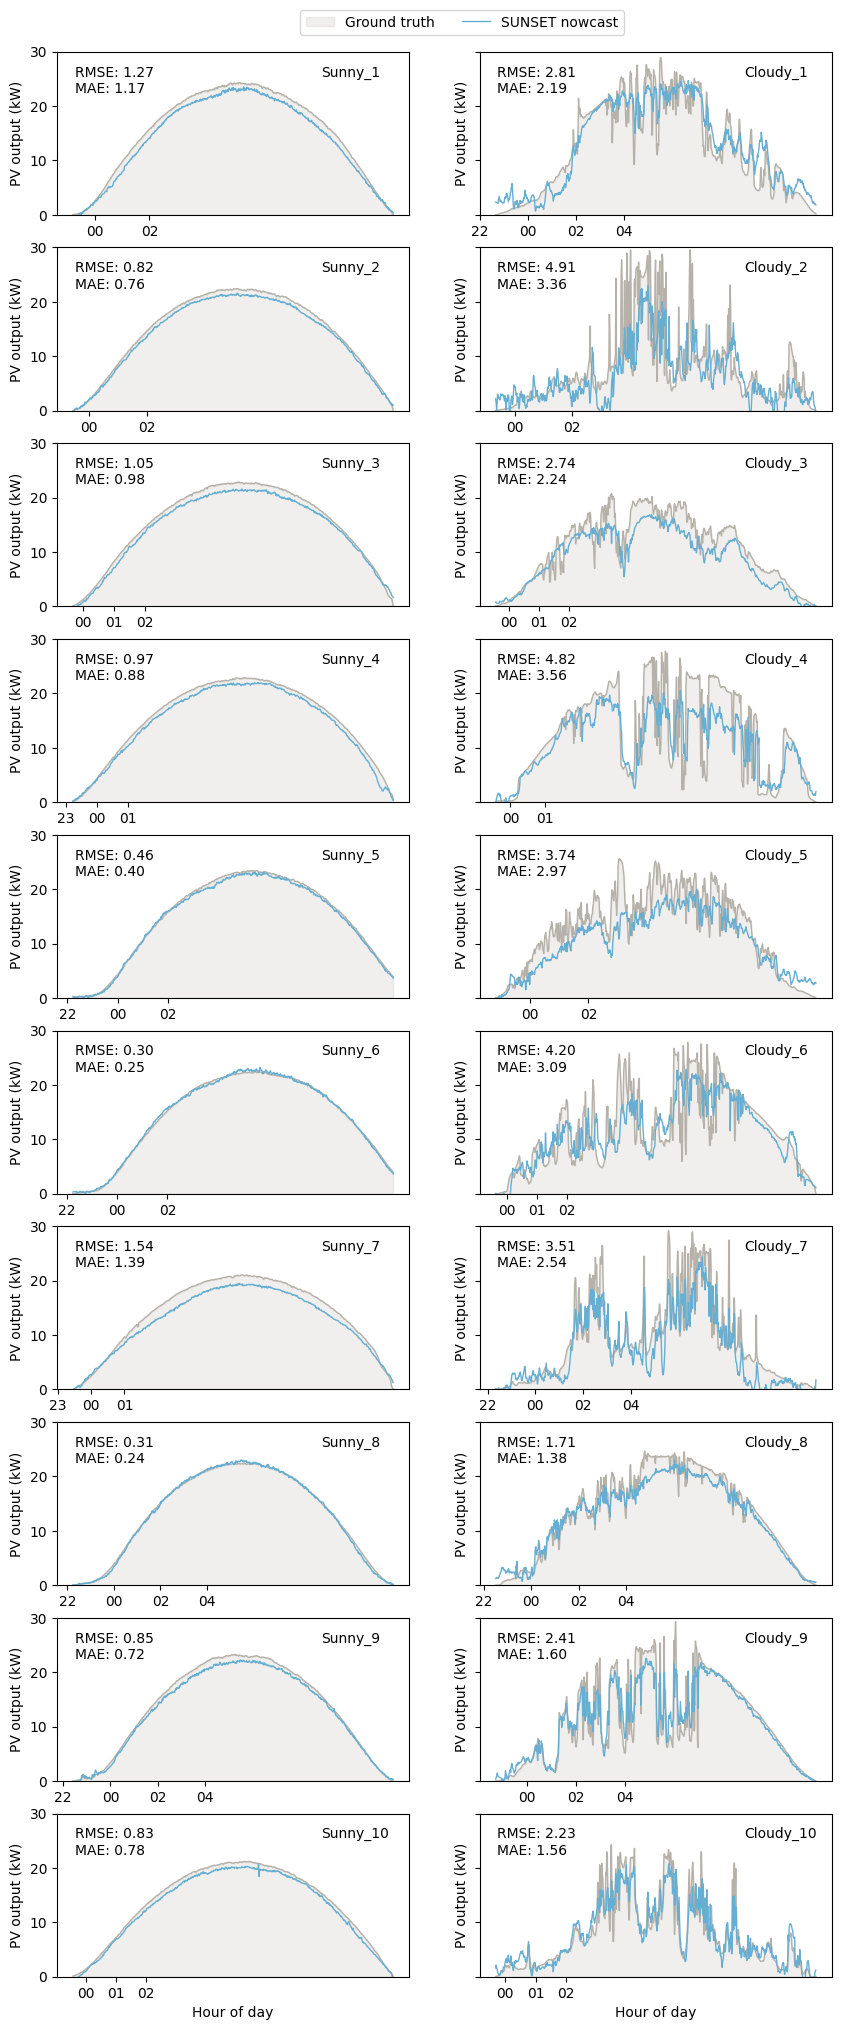

In [28]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i,1]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

    
axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)    
plt.show()  